#Autoencoders

An autoencoder is a type of neural network that learns to compress data into a smaller, more efficient form and then reconstruct it back to its original state. It works in two stages: first, the encoder takes the input data and reduces it to a compact representation by focusing on the most important features. Then, the decoder takes this compressed representation and tries to reconstruct the original data as accurately as possible. The network is trained to minimize the difference between the original input and the reconstructed output, effectively learning the most essential patterns in the data.

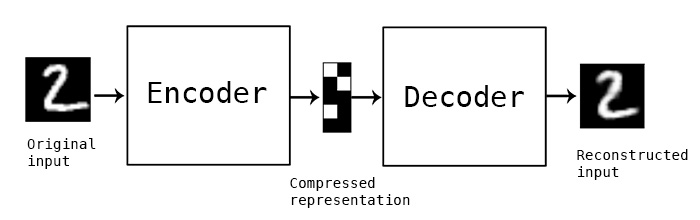

If we apply this to the MNIST database, it is very interesting to see what are the hidden representations are actually learning. We can see that the quality of the image changes when we change the size of the hidden space.

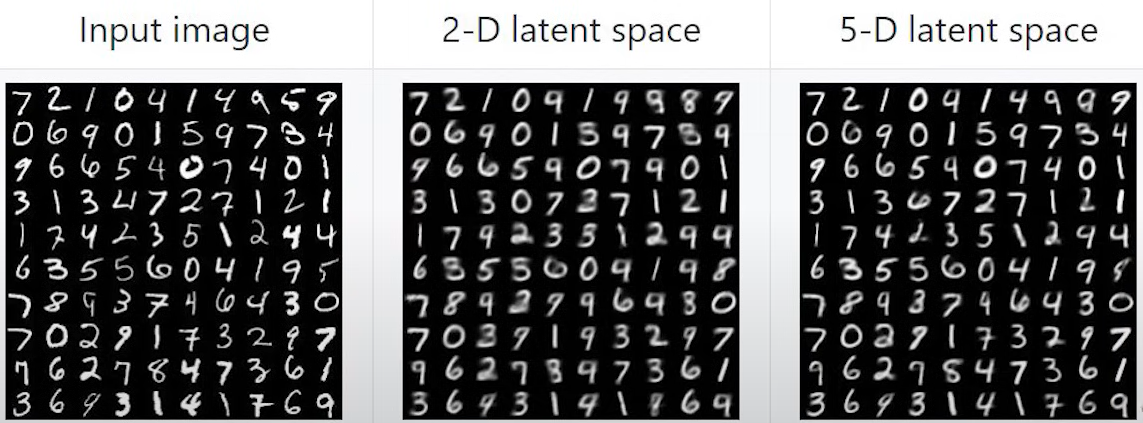

Both the encoder and decoder are a bunch of layers (fully connected or convolutional) that are going to take the input and compress it into a smaller representation which has a lower dimentsionality.

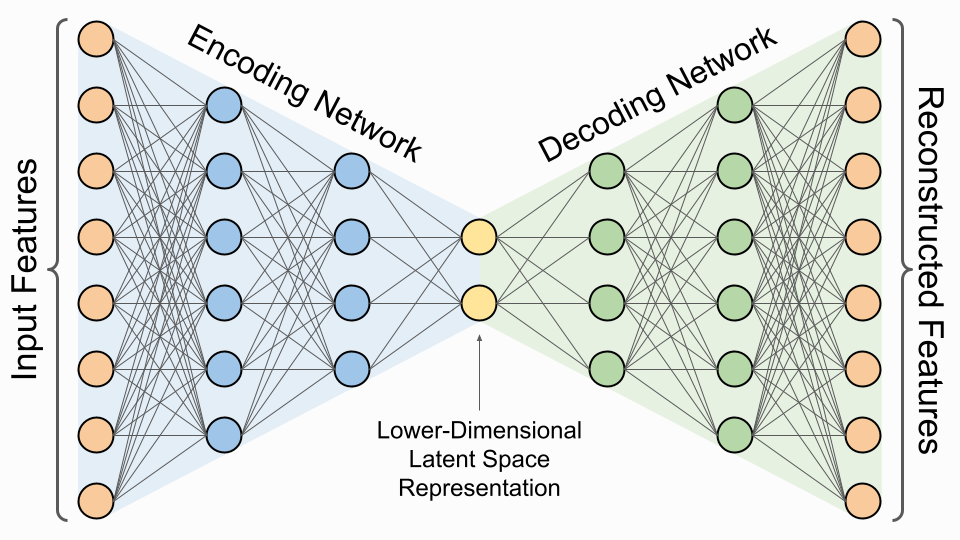

Autoencoders are not entropy-based but rather **deterministic**. They are data-specific and have no generating-capabilities. If you input the same image to an autoencoder 1000 times, you get the same result 1000 times.

# Implementation of Variational AutoEncoder (VAE)

The key difference with VAEs is that instead of mapping your original input into a fixed vector in the hidden space, you map it onto a distribution. The vector in the hidden space is replaced by 2 separate vectors (the mean and the standard deviation of the distribution).

Now, whenever we need to feed a vector to the decoder network, we simply take a sample from the distribution and input it.

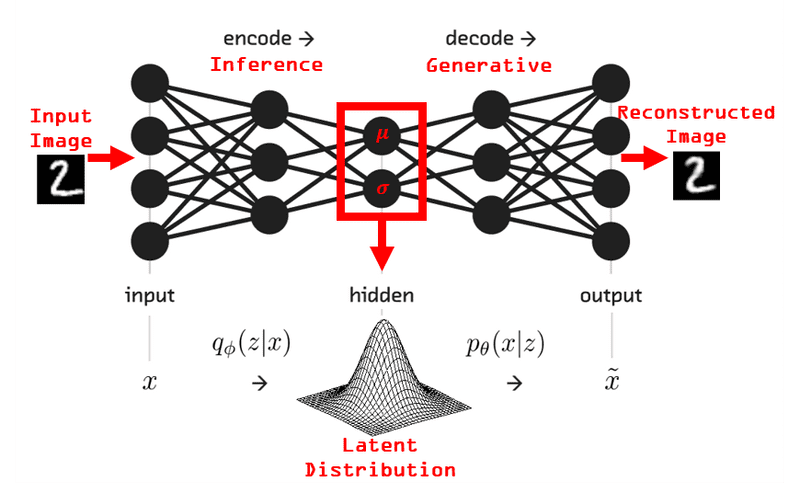

The loss function of the training process has now an extra term to the case of autoencoders which is the KL-divergence term. It measures how far is the learned distribution from the actual distribution of the data.

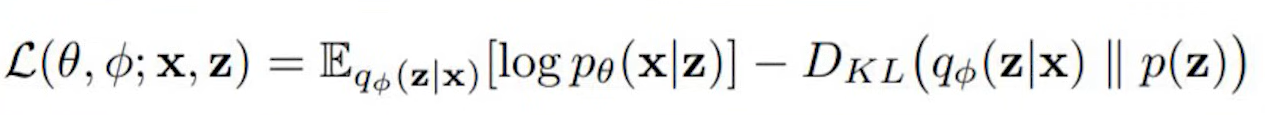

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

###    Hyperparameters

In [2]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:05<00:00, 1889883.23it/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 356403.05it/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2828622.46it/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5479013.16it/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



### Step 2. Define our model: Variational AutoEncoder (VAE)

In [4]:
"""
    A simple implementation of Gaussian MLP (multi-layaer perceptron) Encoder and Decoder (FC).
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       # (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


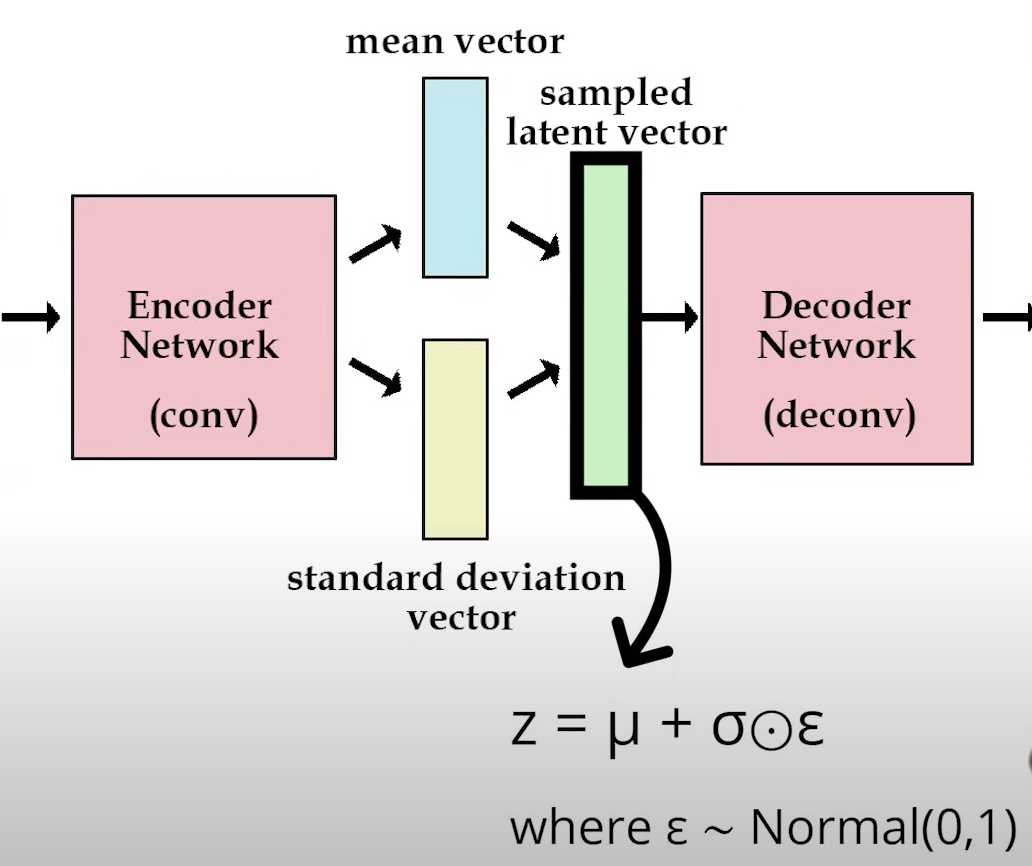

One challenge is that backpropagation is not possible with the existance of a sampling node. One way to solve this is through the reparameterization trick

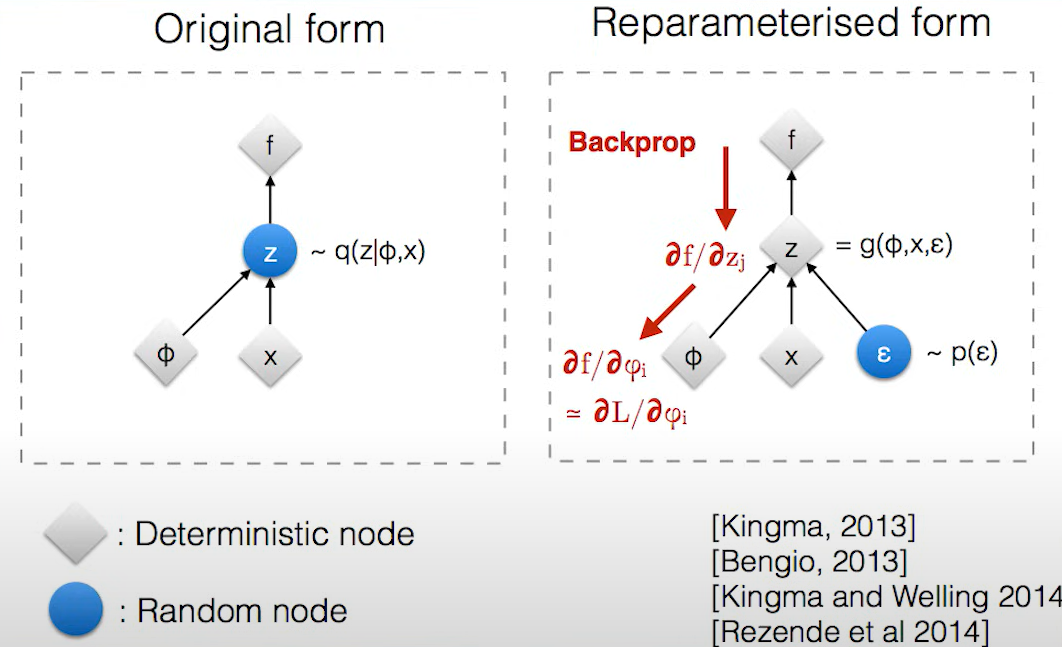

We took out the random nature (stochasticity) from the latent space represented by z and moved it to a separate node (epsilon) that is not involved inteh training.

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


DEVICE                  = "cuda" if torch.cuda.is_available() else "cpu"
model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [8]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [9]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  173.98030053344115
	Epoch 2 complete! 	Average Loss:  128.93935587633035
	Epoch 3 complete! 	Average Loss:  117.33298505321369
	Epoch 4 complete! 	Average Loss:  112.84088110718385
	Epoch 5 complete! 	Average Loss:  110.33884423257513
	Epoch 6 complete! 	Average Loss:  108.35488289401607
	Epoch 7 complete! 	Average Loss:  106.96047003795388
	Epoch 8 complete! 	Average Loss:  106.0915532071682
	Epoch 9 complete! 	Average Loss:  105.23196398294031
	Epoch 10 complete! 	Average Loss:  104.61152955120514
	Epoch 11 complete! 	Average Loss:  104.12084709868009
	Epoch 12 complete! 	Average Loss:  103.60933931226523
	Epoch 13 complete! 	Average Loss:  103.2345439828099
	Epoch 14 complete! 	Average Loss:  102.91612146546328
	Epoch 15 complete! 	Average Loss:  102.65892314012939
	Epoch 16 complete! 	Average Loss:  102.35121711641798
	Epoch 17 complete! 	Average Loss:  102.10137284471514
	Epoch 18 complete! 	Average Loss:  101.90496172005426

### Step 5. Generate images from test dataset

In [10]:
import matplotlib.pyplot as plt

In [11]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [12]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

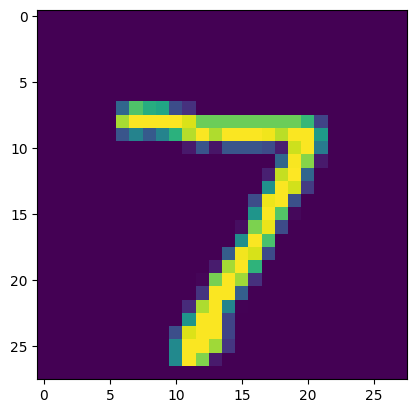

In [13]:
show_image(x, idx=0)

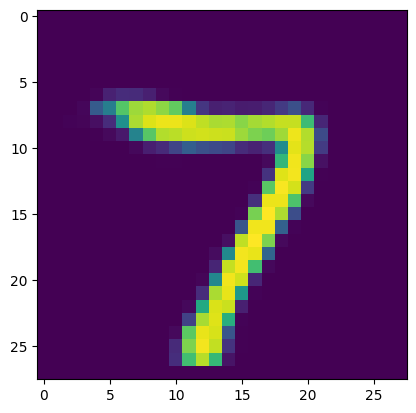

In [14]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [26]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [27]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

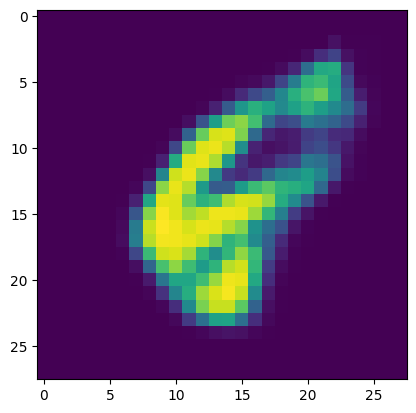

In [28]:
show_image(generated_images, idx=12)

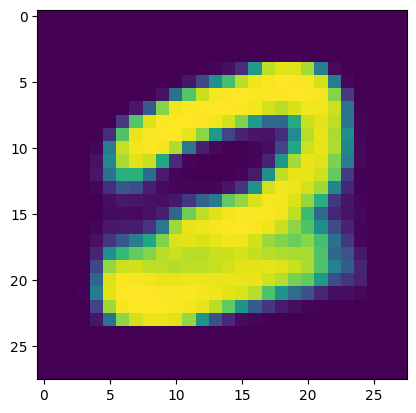

In [29]:
show_image(generated_images, idx=0)

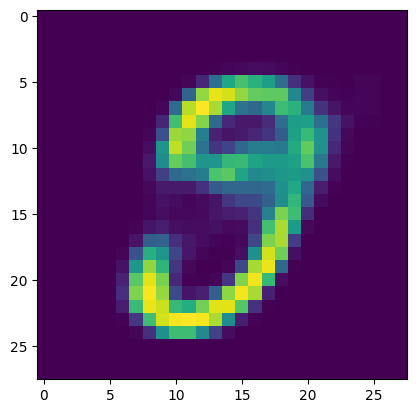

In [30]:
show_image(generated_images, idx=1)

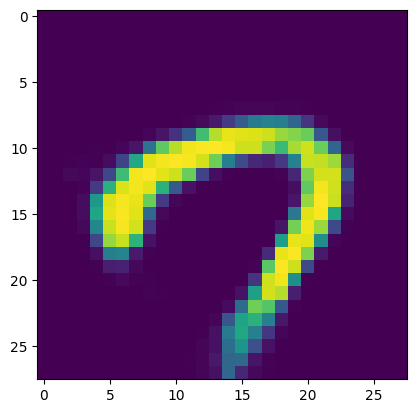

In [31]:
show_image(generated_images, idx=10)

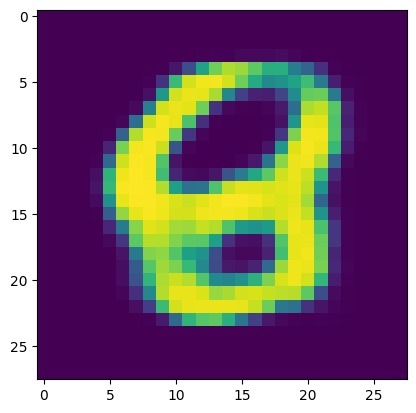

In [32]:
show_image(generated_images, idx=20)

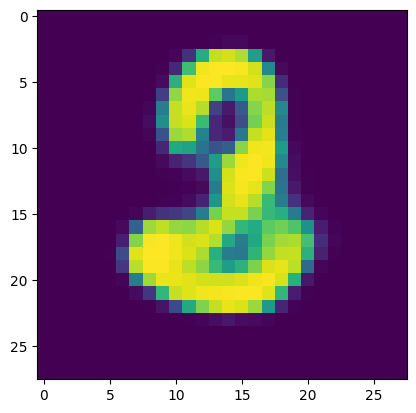

In [33]:
show_image(generated_images, idx=50)